In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn import datasets
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import time

Init Plugin
Init Graph Optimizer
Init Kernel


### Mnist

In [16]:
# dataset MNIST
mnist = tf.keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [17]:
A = train_images.reshape(60000, -1)[40000:50000]
print(A.shape)
b = train_labels[40000:50000] # 10 classes
X = np.random.normal(0, 1, size=(A.shape[1], 10))

mean_A = np.mean(A)
std_A = np.std(A)
A_standardizzato = (A - mean_A) / std_A
A = A_standardizzato

encoder = OneHotEncoder(categories='auto', sparse=False)
B_onehot = encoder.fit_transform(b.reshape(-1,1))

A_test = test_images.reshape(10000, -1)

mean_A = np.mean(A_test)
std_A = np.std(A_test)
A_standardizzato = (A_test - mean_A) / std_A
A_test = A_standardizzato

b_test = test_labels

(10000, 784)


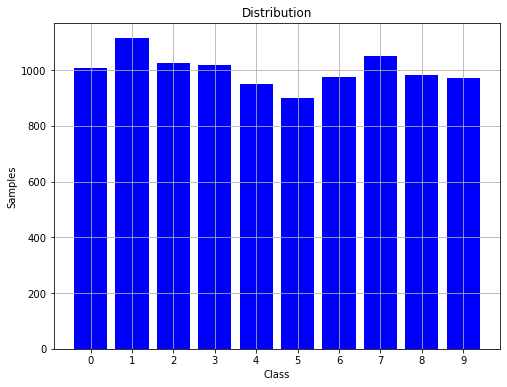

In [18]:
class_distribution = np.bincount(b)
num_classes = len(class_distribution)
classes = np.arange(num_classes)

# Plot
plt.figure(figsize=(8, 6))
plt.bar(classes, class_distribution, color='blue')
plt.xlabel('Class')
plt.ylabel('Samples')
plt.title('Distribution')
plt.xticks(classes)
plt.grid(True)
plt.show()

### Create Data

In [2]:
# Create a 1000x1000 matrix with entries from a normal distribution
X = np.random.normal(0, 1, size=(1000, 50))
A = np.random.normal(0, 1, size=(1500, 1000))
E = np.random.normal(0, 1, size=(1500, 50))

B = np.dot(A, X) + E
b = np.argmax(B, axis=1)

A_test = A[1000:1500]
b_test = b[1000:1500]

A = A[:1000]
b = b[:1000]

encoder = OneHotEncoder(categories='auto', sparse=False)
B_onehot = encoder.fit_transform(b.reshape(-1,1))

In [3]:
A.shape

(1000, 1000)

### Function

In [19]:
def lossFunction(A , B, X):
    Z = A @ X
    return - np.trace(A @ X @ B.T) + np.sum(np.log(np.sum(np.exp(Z), axis=1)))

In [20]:
def mySoftmax(X, A):
    vec = np.dot(A, X) 
    vec_exp = np.exp(vec) 
    res = vec_exp / np.sum(vec_exp, axis=1, keepdims=True)
    return res

def gradient(A, B, X): 
    soft = mySoftmax(X, A)
    gd = - A.T @ (B - soft)
    return gd

In [21]:
def accuracy(y_true, X, A):
    return np.mean(np.argmax(mySoftmax(X, A), axis=1) == y_true)

### Gradient Descent 

00% - loss 268432.20  - acc 21.12%
10% - loss 28412.10  - acc 80.31%
20% - loss 20675.25  - acc 83.40%
30% - loss 16886.27  - acc 85.11%
40% - loss 14307.76  - acc 86.38%
50% - loss 13801.80  - acc 86.09%
60% - loss 11199.02  - acc 87.83%
70% - loss 10255.56  - acc 88.70%
80% - loss 9990.59  - acc 88.11%
90% - loss 9355.31  - acc 88.94%

Final accuracy: 85.28%
Loss: 12681.997899139067



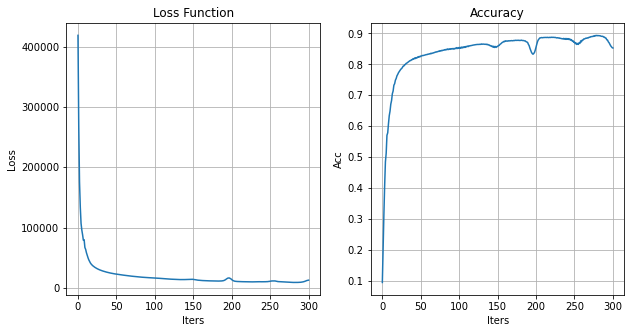

CPU times: user 6min, sys: 4min 20s, total: 10min 21s
Wall time: 2min 3s


In [22]:
%%time

ITERS = 300
EPSILON = 1e-5

X_gd = np.copy(X)
ticks_gd = [0]
losses_gd = [lossFunction(A, B_onehot, X_gd)]
accurances_gd = [accuracy(b, X_gd, A)]

init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0:
        print(f"{int(i/ITERS*100):02}%", end="")
        
    start = time.process_time()
    
    grad = gradient(A, B_onehot, X_gd)
    if EPSILON >= np.linalg.norm(grad): break # Condition
    X_gd = X_gd - 0.0001 * grad # Gradient Step

    ticks_gd.append(time.time() * 1000 - init_time)
    loss = lossFunction(A, B_onehot, X_gd)
    losses_gd.append(np.mean(loss))
    acc = accuracy(b, X_gd, A)
    accurances_gd.append(acc)

    if i % (ITERS * 0.1) == 0:
        print(f" - loss {lossFunction(A, B_onehot, X_gd):05.2f}  - acc {accuracy(b, X_gd, A)*100:05.2f}%", end='\n')

print(f"""
Final accuracy: {round(accurances_gd[-1]* 100, 2)}%
Loss: {lossFunction(A, B_onehot, X_gd)}
""")

plt.figure(figsize=(10, 5))

# Plot
plt.subplot(1, 2, 1)
plt.plot(losses_gd)
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accurances_gd)
plt.xlabel('Iters')
plt.ylabel('Acc')
plt.title("Accuracy")
plt.grid(True)

plt.show()

In [23]:
accuracy(b_test, X_gd, A_test)*100

83.23

### BCGD with GS rule

In [24]:
P = mySoftmax(X, A)
L_max = 0

# Hessian Matrix 
for j in range(P.shape[1]):
    
    Pj = P[:, j]
    Dj = np.diag(Pj * (1 - Pj))
    Hj = np.dot(A.T, np.dot(Dj, A))
    eigenvalues = np.linalg.eigvalsh(Hj)
    Lj = np.max(eigenvalues)
    
    if Lj > L_max:
        L_max = Lj

In [26]:
print(1 / L_max)

2.7459109988841608e-05


00% - loss 401856.54  - acc 09.01%
10% - loss 134227.32  - acc 35.00%
20% - loss 80860.82  - acc 52.70%
30% - loss 61066.31  - acc 61.03%
40% - loss 50942.86  - acc 66.29%
50% - loss 44733.32  - acc 69.65%
60% - loss 40429.61  - acc 72.16%
70% - loss 37250.56  - acc 74.13%
80% - loss 34801.58  - acc 75.71%
90% - loss 32820.59  - acc 76.70%

Final accuracy: 77.52%
Loss: 31212.04848030571



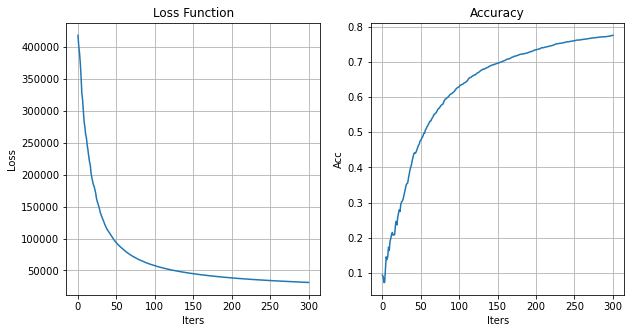

CPU times: user 5min 43s, sys: 4min 30s, total: 10min 13s
Wall time: 2min


In [27]:
%%time

ITERS = 300
EPSILON = 1e-5
X_gd = np.copy(X)

ticks_gdbc = [0]
losses_gdbc = [lossFunction(A, B_onehot, X_gd)]
accurances_gdbc = [accuracy(b, X_gd, A)]

init_time = time.time() * 1000

for i in range(ITERS):
    if i % (ITERS * 0.1) == 0:
        print(f"{int(i/ITERS*100):02}%", end="")
        
    start = time.process_time()

    grad = gradient(A, B_onehot, X_gd)
    norms = np.linalg.norm(grad, axis=0) #row 1, col 0
    numblock = np.argmax(norms)
    X_gd[:, numblock] -= (1 / L_max) * 2.7 * grad[:, numblock] # axis=0 
    #X_gd[numblock] -= (1 / L) * grad[numblock] # axis=1

    ticks_gdbc.append(time.time() * 1000 - init_time)
    loss = lossFunction(A, B_onehot, X_gd)
    losses_gdbc.append(np.mean(loss))
    acc = accuracy(b, X_gd, A)
    accurances_gdbc.append(acc)

    if i % (ITERS * 0.1) == 0:
        print(f" - loss {lossFunction(A, B_onehot, X_gd):05.2f}  - acc {accuracy(b, X_gd, A)*100:05.2f}%", end='\n')

print(f"""
Final accuracy: {round(accurances_gdbc[-1]* 100, 2)}%
Loss: {lossFunction(A, B_onehot, X_gd)}
""")

plt.figure(figsize=(10, 5))

# Plot della loss
plt.subplot(1, 2, 1)
plt.plot(losses_gdbc)
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accurances_gdbc)
plt.xlabel('Iters')
plt.ylabel('Acc')
plt.title("Accuracy")
plt.grid(True)

plt.show()

In [12]:
accuracy(b_test, X_gd, A_test)*100

95.0

## Results

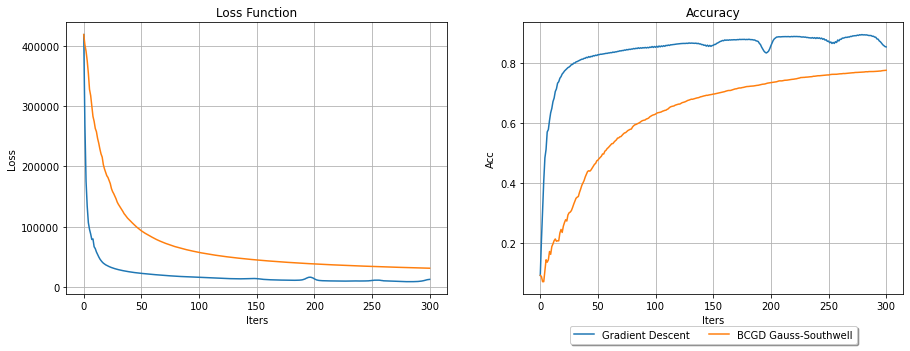

In [28]:
plt.figure(figsize=(15, 5))

# Plot
plt.subplot(1, 2, 1)
plt.plot(losses_gd)
plt.plot(losses_gdbc)
plt.xlabel('Iters')
plt.ylabel('Loss')
plt.title('Loss Function')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(accurances_gd)
plt.plot(accurances_gdbc)
plt.xlabel('Iters')
plt.ylabel('Acc')
plt.title("Accuracy")
plt.grid(True)

plt.legend(
    [
        'Gradient Descent',
        'BCGD Gauss-Southwell',
    ],
    loc="center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

plt.show()

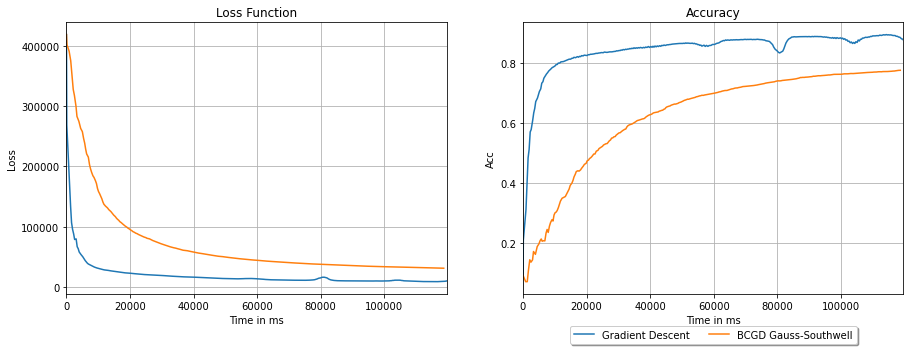

In [29]:
plt.figure(figsize=(15, 5))

# Plot della loss
plt.subplot(1, 2, 1)
plt.plot(ticks_gd, losses_gd)
plt.plot(ticks_gdbc, losses_gdbc)
plt.xlabel('Time in ms')
plt.xlim(-10,max(ticks_gdbc) + 1000)
plt.ylabel('Loss')
plt.title('Loss Function')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(ticks_gd, accurances_gd)
plt.plot(ticks_gdbc, accurances_gdbc)
plt.xlabel('Time in ms')
plt.xlim(-10,max(ticks_gdbc) + 1000)
plt.ylabel('Acc')
plt.title("Accuracy")
plt.grid(True)

plt.legend(
    [
        'Gradient Descent',
        'BCGD Gauss-Southwell',
    ],
    loc="center",
    bbox_to_anchor=(0.5, -0.15),
    fancybox=True, shadow=True, ncol=2
)

plt.show()